# Анализ развития интернет-магазина

## Техническое задание

1.	Какой рекламный канал принёс больше всего дохода за всё время?
2.	Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)
3.	Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?
4.	Необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. 
Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам понадобятся?

В проекте используются библиотеки pabdas, matplotlib, numpy, scipy, catboost, sklearn. Доход магазина прогнозируется как временной ряд с помощью градиентного бустинга catboost. Для анализа разницы срдених в разных группах используются t-тесты. Также в проекте присутствует часть EDA.



---



---


## Подготовка данных

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

Читаем базы данных.

In [ ]:
df = pd.read_csv('/content/summer_camp_data.xls.csv', encoding = "koi8_r")
display(df.head().T)
df.info()

,0,1,2,3,4
date,2020-05-11,2020-05-11,2020-05-11,2020-05-11,2020-05-11
source,google,yandex,google,google,yandex
medium,organic,cpc,cpc,cpc,organic
delivery_available,мЕ НОПЕДЕКЕМН,мЕ НОПЕДЕКЕМН,мЕ НОПЕДЕКЕМН,мЕ НОПЕДЕКЕМН,мЕ НОПЕДЕКЕМН
device_type,дЕЯЙРНО,лНАЮИК,лНАЮИК,дЕЯЙРНО,дЕЯЙРНО
promo_activated,no,yes,no,no,no
filter_used,no,no,no,no,no
pageviews,3120,3302,2970,1875,2159
visits,1233,544,1450,854,1000
productClick,5240,9930,5460,4250,4110


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52724 entries, 0 to 52723
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                52724 non-null  object 
 1   source              52724 non-null  object 
 2   medium              52724 non-null  object 
 3   delivery_available  52724 non-null  object 
 4   device_type         52724 non-null  object 
 5   promo_activated     52724 non-null  object 
 6   filter_used         52724 non-null  object 
 7   pageviews           52724 non-null  int64  
 8   visits              52724 non-null  int64  
 9   productClick        52724 non-null  int64  
 10  addToCart           52724 non-null  int64  
 11  checkout            52724 non-null  int64  
 12  transactions        52724 non-null  int64  
 13  revenue             52724 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 5.6+ MB


Мы получили базу данных из 13 признаков. Всего в базе 52724 записей без пропусков. Нужно заменить текст в переменных `delivery_available` и `device_type` на читаемый.

In [ ]:
df['delivery_available'].unique()

array(['мЕ НОПЕДЕКЕМН', 'дНЯРЮБЙЮ ЕЯРЭ', 'дНЯРЮБЙХ МЕР'], dtype=object)

In [ ]:
df['device_type'].unique()

array(['дЕЯЙРНО', 'лНАЮИК', 'мЕ НОПЕДЕКЕМН'], dtype=object)

In [ ]:
df = df.replace({'мЕ НОПЕДЕКЕМН': 'not_defined',
            'дНЯРЮБЙЮ ЕЯРЭ': 'delivery_yes',
            'дНЯРЮБЙХ МЕР': 'delivery_no',
            'дЕЯЙРНО': 'desktop',
            'лНАЮИК': 'mobile'})
display(df.head().T)

,0,1,2,3,4
date,2020-05-11,2020-05-11,2020-05-11,2020-05-11,2020-05-11
source,google,yandex,google,google,yandex
medium,organic,cpc,cpc,cpc,organic
delivery_available,not_defined,not_defined,not_defined,not_defined,not_defined
device_type,desktop,mobile,mobile,desktop,desktop
promo_activated,no,yes,no,no,no
filter_used,no,no,no,no,no
pageviews,3120,3302,2970,1875,2159
visits,1233,544,1450,854,1000
productClick,5240,9930,5460,4250,4110


In [ ]:
df.duplicated().sum()

0

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek



---



---


## Описание данных
Посмотрим на распределение переменных.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pageviews,52724.0,445.797853,1108.633081,0.0,12.0,47.0,256.00,26589.0
visits,52724.0,127.219312,385.094298,1.0,2.0,7.0,41.00,6975.0
productClick,52724.0,891.086981,2101.027285,0.0,20.0,90.0,520.00,32460.0
addToCart,52724.0,178.040740,419.992820,0.0,4.0,18.0,104.00,6486.0
checkout,52724.0,146.593620,344.664158,0.0,3.0,15.0,83.00,3857.0
transactions,52724.0,20.092823,52.436046,0.0,0.0,2.0,11.00,1113.0
revenue,52724.0,24198.414180,63821.182490,0.0,0.0,2445.5,13297.75,1397420.0
month,52724.0,5.109400,2.549471,1.0,3.0,5.0,7.00,9.0
dayofweek,52724.0,3.051703,1.996189,0.0,1.0,3.0,5.00,6.0


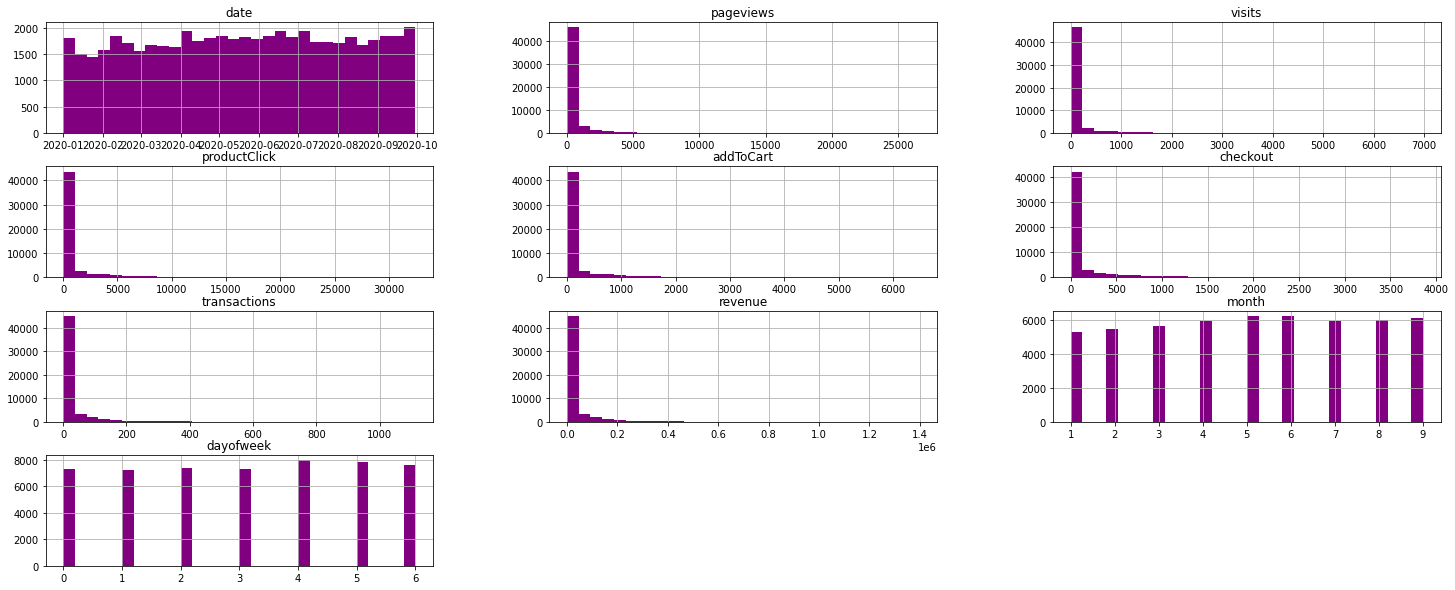

In [ ]:
df.hist(bins=30, color = 'Purple', figsize = (25,10))
plt.show()

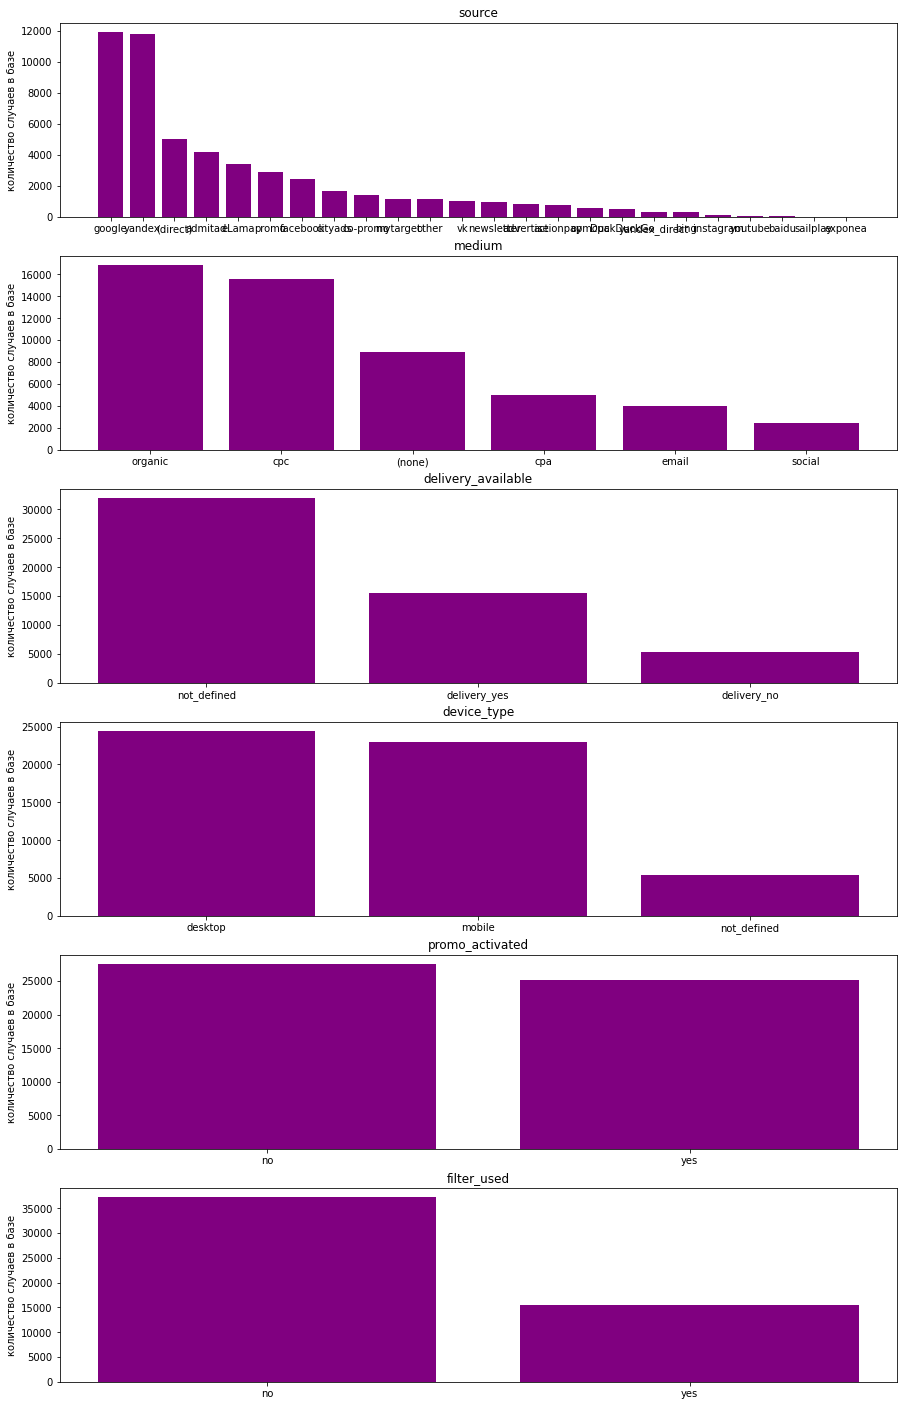

In [ ]:
fig, axs = plt.subplots(6, figsize=(15, 25))

def draw_plots(i, variable:str):
    axs[i].set_title(variable)
    axs[i].set_ylabel("количество случаев в базе")
    axs[i].bar(df[variable].unique(), df[variable].value_counts(), color = 'purple')

for i, variable in enumerate(['source', 'medium', 'delivery_available', 'device_type', 'promo_activated', 'filter_used']):
    draw_plots(i, variable)

plt.show()

Группы достаточно равнонаполнены для перекрёстного анализа, кроме переменной источника перехода пользователя. В основном это Яндекс и Google, скорее всего, органические переходы.

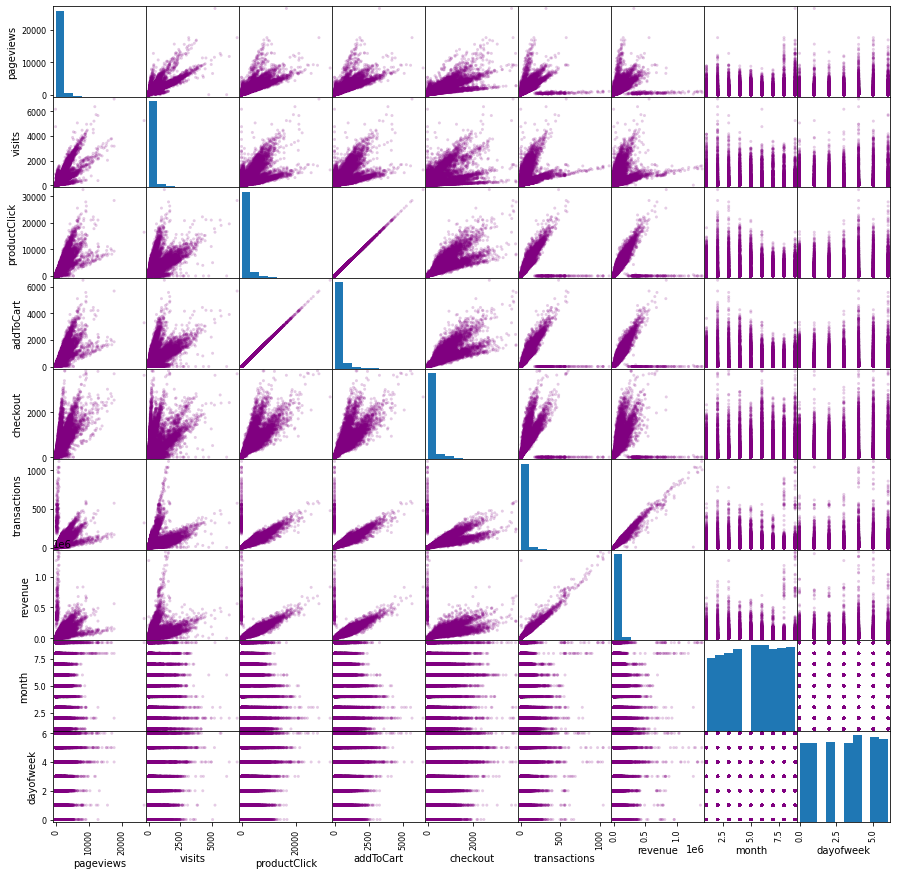

In [ ]:
pd.plotting.scatter_matrix(
    df,
    alpha=0.2,
    color = 'purple',
    figsize = (15, 15))
plt.show()

Существенная часть пользователей заходит на сайт, не совершая никаких действий. Возможно, это "случайные" клики на рекламные баннеры или переходы по ссылкам в поисковой выдаче.

С другой стороны, есть группа пользователей, которые совершают покупки (`transactions` и `revenue` при крайне малом количестве кликов, просмотров страниц и т.д.) Т.к. они и не добавляют товары в корзину, а совершают покупки, можно предположить, что это отложенный спрос (пользователи положили товары в корзины и вернулись к ним позже). Эта группа может завышать или занижать количество покупок в отдельные периоды времени, поэтому необходимо решить, стоит ли их исключать из анализа.

Переменные `productClick` и `addToCart` практически идентичны. Также крайне схожи столбцы `transactions` и `revenue`.

Корреляционная матрица показывает, что переменные в нашей базе достаточно тесно связаны: если пользователь совершает покупку, он проходит на несколько страниц, совершает клики, проходит в корзину и т.д. Примечательно, что на многих перекрёстных графиках количественных переменных видно, что есть группы пользователей (например, два однонаправленных тренда на графике связи количества `checkout` и `transactions`), посмотрим, связано ли это с пандемией:

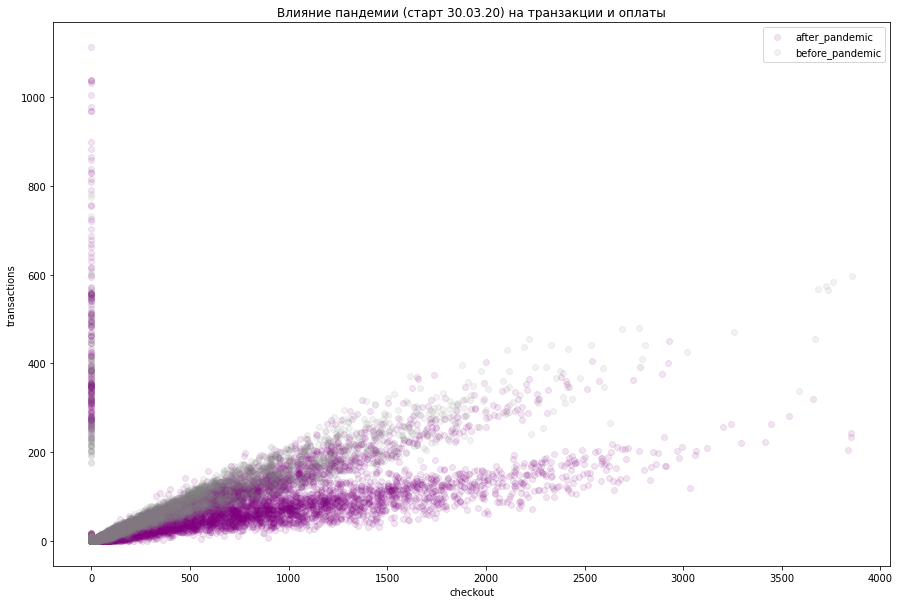

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(df.query("date > '2020-03-30'")['checkout'], df.query("date > '2020-03-30'")['transactions'], color='purple', alpha = 0.1)
plt.scatter(df.query("date < '2020-03-30'")['checkout'], df.query("date < '2020-03-30'")['transactions'], color='grey', alpha = 0.1)

plt.title('Влияние пандемии (старт 30.03.20) на транзакции и оплаты')
plt.ylabel('transactions')
plt.xlabel('checkout')
plt.legend(["after_pandemic","before_pandemic"])
plt.show()

Действительно, несмотря на тесную связь переменных, пандемия внесла изменения в потребительское поведение. После начала самоизоляции в Москве, а затем и в регионах пользователи выполняли больше оформлений (чекаутов), но меньше оплат (транзакций). Возможно, во время пандемии был паттерн потребительского поведения, при котором потребители проводили время за онлайн-шоппингом ради развлечения, добавляли товары в корзины, не планируя их оплатить. Также ситуация может быть связана с неработающими промокодами (именно в процессе чекаута пользователь обнаруживает неработающий промокод и отказывается от оплаты).



---



---


## Какой рекламный канал принёс больше всего дохода за всё время?

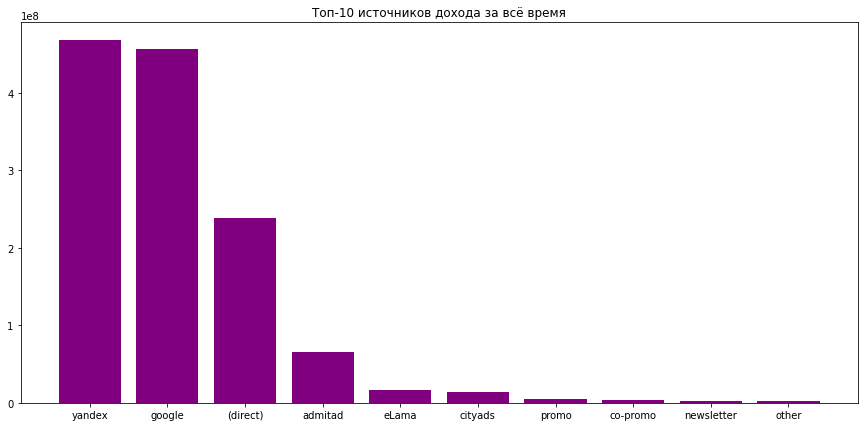

,source,sum
0,yandex,467000000.0
1,google,457000000.0
2,(direct),238000000.0
3,admitad,66000000.0
4,eLama,16000000.0
5,cityads,14000000.0
6,promo,5000000.0
7,co-promo,3000000.0
8,newsletter,2000000.0
9,other,2000000.0


In [ ]:
source_by_sum = pd.pivot_table(df, index=['source'], values='revenue', aggfunc={'sum'}).sort_values(by = 'sum', ascending = False).reset_index().head(10)
plt.figure(figsize=(15, 7))
plt.bar(x = source_by_sum['source'], height = source_by_sum['sum'], color = 'Purple')
plt.title('Топ-10 источников дохода за всё время')
plt.show()
source_by_sum.round(-6)

**Вывод**: ранее мы видели, что источник `google` даёт чуть больше переходов, тем не менее `yandex` приносит больший суммарный доход (около 467 млн. единиц). Однако это не значит большую эффективность данного источника. Для анализа ROMI необходимо учитывать LTV привлечённых пользователей, а также затраченный на привлечение каждого пользователя расход (за вычетом партнёрских размещений, если за реклама интернет-магазина шла совместно с продаваемым брендом).



---


## Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без?

Введём новую переменную срденего чека, разделив `revenue` на transactions. В случае нулевых транзакций стоит ли ставить нулевой средний чек, необходимо уточнить у заказчика, ситуация до и после пандемии различная. Допустим, заменить пропуски на нули будет корректно.

In [ ]:
df['avg_payment'] = df['revenue'] / df['transactions']
df['avg_payment'] = df['avg_payment'].fillna(0)
#df = df.dropna()

In [ ]:
promo_by_months = (df.pivot_table(
    index=['month'],
    columns='promo_activated',
    values='avg_payment',
    aggfunc='mean').reset_index())                  

promo_by_months['both'] = pd.pivot_table(df, index=['month'], values='avg_payment', aggfunc={'mean'}).reset_index()['mean']
promo_by_months = promo_by_months.round(0)
promo_by_months

promo_activated,month,no,yes,both
0,1,841.0,1011.0,917.0
1,2,933.0,1065.0,994.0
2,3,947.0,1006.0,975.0
3,4,792.0,879.0,835.0
4,5,786.0,948.0,866.0
5,6,755.0,904.0,828.0
6,7,846.0,995.0,917.0
7,8,797.0,947.0,868.0
8,9,751.0,908.0,826.0


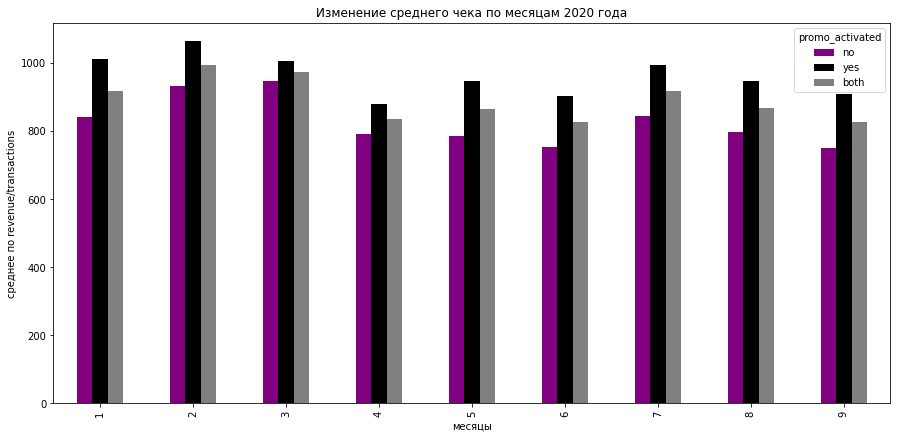

In [ ]:
promo_by_months.plot(
    x='month', y=['no', 'yes', 'both'], kind='bar',  color = ['purple','black','grey'],
    figsize = (15,7)
)
plt.title('Изменение среднего чека по месяцам 2020 года')
plt.xlabel('месяцы')
plt.ylabel('среднее по revenue/transactions')
plt.show()

In [ ]:
alpha = 0.05
labels = ['Вся база', 'С использованием промокодов', 'Без использования промокода']

a_data = df.loc[df['month'] <= 3, 'avg_payment']
b_data = df.loc[df['month'] > 3, 'avg_payment']
_, p_value = st.ttest_ind(a_data, b_data, equal_var=False)
    
print(p_value)
print(labels[0])
if p_value > alpha:
    print('До и после пандемии нет значимых отличий')
else:
    print('До и после пандемии ЕСТЬ значимые отличия')
print(f'До марта включительно средний чек {round(a_data.mean())} единиц')
print(f'После - {round(b_data.mean())} единиц')
print()

a_data = df.query("promo_activated == 'yes'").loc[df['month'] <= 3, 'avg_payment']
b_data = df.query("promo_activated == 'yes'").loc[df['month'] > 3, 'avg_payment']
_, p_value = st.ttest_ind(a_data, b_data, equal_var=False)
    
print(p_value)
print(labels[1])
if p_value > alpha:
    print('До и после пандемии нет значимых отличий')
else:
    print('До и после пандемии ЕСТЬ значимые отличия')
print(f'До марта включительно средний чек {round(a_data.mean())} единиц')
print(f'После - {round(b_data.mean())} единиц')
print()

a_data = df.query("promo_activated == 'no'").loc[df['month'] <= 3, 'avg_payment']
b_data = df.query("promo_activated == 'no'").loc[df['month'] > 3, 'avg_payment']
_, p_value = st.ttest_ind(a_data, b_data, equal_var=False)
    
print(p_value)
print(labels[2])
if p_value > alpha:
    print('До и после пандемии нет значимых отличий')
else:
    print('До и после пандемии ЕСТЬ значимые отличия')
print(f'До марта включительно средний чек {round(a_data.mean())} единиц')
print(f'После - {round(b_data.mean())} единиц')
print()

4.207123682300066e-18
Вся база
До и после пандемии ЕСТЬ значимые отличия
До марта включительно средний чек 963 единиц
После - 857 единиц

7.912202559068006e-29
С использованием промокодов
До и после пандемии ЕСТЬ значимые отличия
До марта включительно средний чек 1027 единиц
После - 930 единиц

2.4250621426909047e-08
Без использования промокода
До и после пандемии ЕСТЬ значимые отличия
До марта включительно средний чек 907 единиц
После - 788 единиц



**Вывод**: средние чеки всех групп пользователей снизились с началом самоизоляции в апреле. Примечательно, что средний чек использующих промокоды начиная с мая стал драматично выше, чем у тех, кто им не пользовался. Если не заменять средние чеки нулевых транзакций на нули, данные будут отличаться, средний чеки на 500 единиц выше, но с уверенностью 95% всё равно можно сказать, что пандемия существенно изменила средний чек потребителя. Так, среди всех пользователей он был 963 единицы до марта включительно и 857 - после. Среди использовавших промокоды - 1027 до марта и 930 - после. 



---



---


## Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?

Введём новую переменную CR, разделив `transactions` на `visits`. Как и в случае средних чеков, нулевые транзакций вновь ставят вопрос, стоит ли присваивать нулевую конверсию при нулевых транзакциях. Допустим, в результате обсуждения мы пришли к выводу, что стоит.

In [ ]:
df['CR'] = df['transactions'] / df['visits']
df['CR'] = df['CR'].fillna(0)

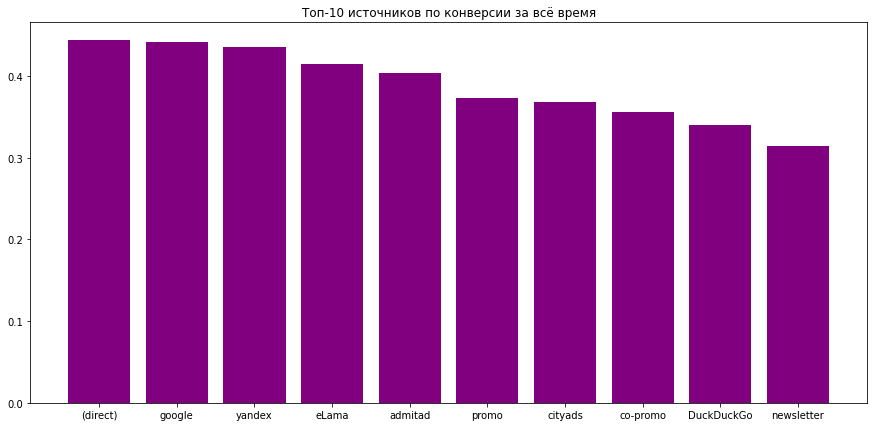

,source,mean
0,(direct),0.443725
1,google,0.442028
2,yandex,0.435289
3,eLama,0.415004
4,admitad,0.403512
5,promo,0.372631
6,cityads,0.368611
7,co-promo,0.355771
8,DuckDuckGo,0.339598
9,newsletter,0.314544


In [ ]:
source_by_cr = pd.pivot_table(df, index=['source'], values='CR', aggfunc={'mean'}).sort_values(by = 'mean', ascending = False).reset_index().head(10)
plt.figure(figsize=(15, 7))
plt.bar(x = source_by_cr['source'], height = source_by_cr['mean'], color = 'Purple')
plt.title('Топ-10 источников по конверсии за всё время')
plt.show()
source_by_cr

Доходы приносят переходы из поисковиков, однако обычно это достаточно дорогой ресурс (поддержание общего информационного фона, имиджа). `(direct)` (возможно, речь о переходе по прямым ссылкам) приносит особых пользователей - возможно, их не так много, это не самая доходная группа, однако конверсия у этого ресурса выше, это важно.

In [ ]:
alpha = 0.05

a_data = df.loc[df['dayofweek'] <= 4, 'CR']
b_data = df.loc[df['dayofweek'] > 4, 'CR']
_, p_value = st.ttest_ind(a_data, b_data, equal_var=False)
    
print(p_value)
if p_value > alpha:
    print('Между будними и выходными нет значимых отличий')
else:
    print('Между будними и выходными ЕСТЬ значимые отличия')
print(f'В буднии средняя конверсия составила {a_data.mean()}')
print(f'В выходные - {b_data.mean()}')

8.365213081619752e-11
Между будними и выходными ЕСТЬ значимые отличия
В буднии средняя конверсия составила 0.3762875491723764
В выходные - 0.4000723926807693


**Вывод**: хоть разница всего в 2,4%, она всё же значимая (с уверенностью 95%). В выходные пользователи более прицельно заходят на исследуемый интернет-сервис. Также стоит обратить внимание на ресурс `(direct)` - конверсия этих пользователей выше, чем полученных от `yandex` и `google`.



---



---


##Необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед.

В данном случае целесообразно воспользоваться анализом временных рядов. Данных для этого недостаточно (у нас в распоряжении всего 9 месяцев для анализа, новогодние распродажи могут сильно повлиять на изменение потребительского поведения). Ниже мы будем наблюдать снижение выручки по каналу контекстной рекламы в качестве тренда, однако, чтобы утверждать более точно нам нужно проанализировать годовую сезонность и сверить тренд на снижение эффективности контекстной рекламы со смежными бизнесами.

Далее покажем пример анализа временных рядов. Формируем датасет из двух столбцов - выручка и дата.

In [ ]:
df_cpc = df.query("medium == 'cpc'")[['revenue', 'date']]
df_cpc.sample(5)

,revenue,date
13040,26182.0,2020-05-16
52655,3486.0,2020-04-11
7329,188205.0,2020-03-23
48250,2649.0,2020-05-01
1631,69487.0,2020-09-23


Ряд должен стать монотонным (от старых дат к новым):

In [ ]:
df_cpc = df_cpc.sort_values('date').set_index('date')
df_cpc.index.is_monotonic

True

У нас по несколько записей на в таблице на каждый день, однако данных по часам нет, поэтому целесообразно сделать ресемплинг по дням. Таким образом, мы сокращаем выборку до 274 дней.

In [ ]:
df_cpc = df_cpc.resample('1D').sum()

Посмотрим на полученные данные:

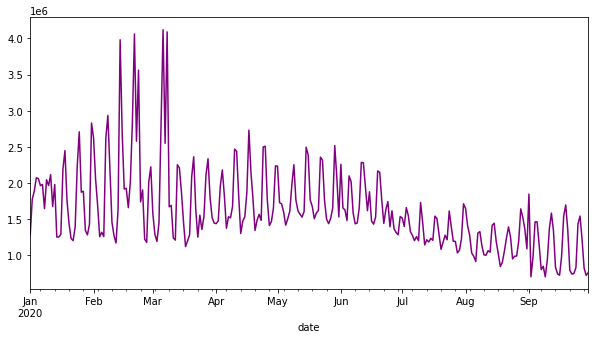

In [ ]:
df_cpc['revenue'].plot(color = 'Purple', figsize = (10,5))
None

Ряд нестационарен. Наблюдается сезонность в течение недели. Также продажи разнятся от месяца к месяцу и внутри месяца. Добавим скользящее среднее с разными "окнами":

In [ ]:
df_cpc['rolling_mean10'] = df_cpc['revenue'].rolling(10).mean()
df_cpc['rolling_mean100'] = df_cpc['revenue'].rolling(100).mean()
df_cpc['rolling_mean500'] = df_cpc['revenue'].rolling(500).mean()

Посмотрим на полученный тренд:

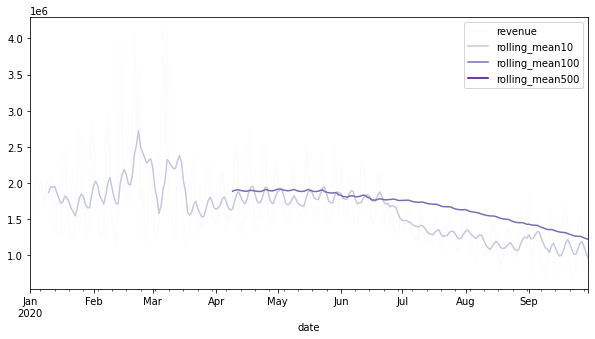

In [ ]:
df_cpc.plot(figsize = (10,5), colormap = 'Purples')
None

Тренд на снижение пользовательского отклика на контекстную рекламу (хотя у нас данные неполные, возможно, заказчик снижает объём контекстной рекламы). Добавим переменные дат и сдвиг в анализируемую базу:

In [ ]:
def make_features(df_cpc, max_lag, rolling_mean_size):
    df_cpc['dayofweek'] = df_cpc.index.dayofweek
    df_cpc['month'] = df_cpc.index.month
    df_cpc['day'] = df_cpc.index.day

    for lag in range(1, max_lag + 1):
        df_cpc['lag_{}'.format(lag)] = df_cpc['revenue'].shift(lag)

    df_cpc['rolling_mean_shift'] = df_cpc['revenue'].shift().rolling(rolling_mean_size).mean()

make_features(df_cpc, 3, 10)
df_cpc

,revenue,rolling_mean10,rolling_mean100,rolling_mean500,dayofweek,month,day,lag_1,lag_2,lag_3,rolling_mean_shift
date,,,,,,,,,,,
2020-01-01,1278862.0,NaN,NaN,NaN,2,1,1,NaN,NaN,NaN,NaN
2020-01-02,1774136.0,NaN,NaN,NaN,3,1,2,1278862.0,NaN,NaN,NaN
2020-01-03,1889112.0,NaN,NaN,NaN,4,1,3,1774136.0,1278862.0,NaN,NaN
2020-01-04,2072428.0,NaN,NaN,NaN,5,1,4,1889112.0,1774136.0,1278862.0,NaN
2020-01-05,2061834.0,NaN,NaN,NaN,6,1,5,2072428.0,1889112.0,1774136.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-26,1543668.0,1167885.1,1263958.97,NaN,5,9,26,1435699.0,830729.0,749016.0,1086027.4
2020-09-27,1221810.0,1190801.8,1254507.39,NaN,6,9,27,1543668.0,1435699.0,830729.0,1167885.1
2020-09-28,823270.0,1118993.1,1241252.49,NaN,0,9,28,1221810.0,1543668.0,1435699.0,1190801.8


Подготовим выборку к прогнозированию:

In [ ]:
train, test = train_test_split(df_cpc, shuffle=False, test_size=0.2)

In [ ]:
model = CatBoostRegressor(loss_function="RMSE", iterations=90)
model.fit(train.drop(['revenue'], axis=1), train['revenue'])
pred_test = model.predict(test.drop(['revenue'], axis=1))

print(f"Средняя абсолютная ошибка предсказания:{mean_absolute_error(test['revenue'], pred_test)}")

Learning rate set to 0.228124
0:	learn: 496849.6454465	total: 48ms	remaining: 4.28s
1:	learn: 451093.7082098	total: 49.6ms	remaining: 2.18s
2:	learn: 418347.4943750	total: 51.3ms	remaining: 1.49s
3:	learn: 388190.7507102	total: 52.7ms	remaining: 1.13s
4:	learn: 366565.0757758	total: 54.1ms	remaining: 919ms
5:	learn: 342406.5035384	total: 55.5ms	remaining: 776ms
6:	learn: 330946.5450969	total: 57.2ms	remaining: 678ms
7:	learn: 310322.5183769	total: 58.8ms	remaining: 603ms
8:	learn: 299004.4885635	total: 60.2ms	remaining: 542ms
9:	learn: 284936.5646043	total: 61.9ms	remaining: 495ms
10:	learn: 274276.7704974	total: 63.6ms	remaining: 457ms
11:	learn: 264344.3913219	total: 65.3ms	remaining: 424ms
12:	learn: 253942.4364995	total: 67ms	remaining: 397ms
13:	learn: 246600.6585017	total: 68.6ms	remaining: 372ms
14:	learn: 238456.4229220	total: 70.3ms	remaining: 351ms
15:	learn: 232101.1956792	total: 71.9ms	remaining: 333ms
16:	learn: 225564.6686760	total: 73.6ms	remaining: 316ms
17:	learn: 2194

**Вывод**: если отделить 55 дней (20%) от текущей выборки в 274 дня, то можно предсказать объём выручки от канала контекстной рекламы со средней ошибкой в 173 тысячи единиц в день при средней выручке примерно в 1,5 млн в день. Чем больше будет срок предсказания, тем менее точным будет прогноз за счёт воздействия различных факторов. Для прогноза на 6 месяцев необходимы данные за 2-3 предыдущих года, чтобы проанализировать дневную, месячную, квартальную, годовую сезонность. Также стоит из внешних источников найти данные, подтверждающие или опровергающие снижение отклика пользователей на контекстную рекламу в целом.